In [110]:
#%matplotlib inline
import argparse
import os
import random
import logging
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


### Load data & choose device

In [122]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dogdataset = dset.ImageFolder(root="Images",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dogdataset, batch_size=256,
                                         shuffle=True, num_workers=2)


#determine device: cpu/gpu
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print('using device:', device)


num_epochs = 80

using device: cuda


In [123]:
len(dataloader)

81

### Visualize dog dataset 

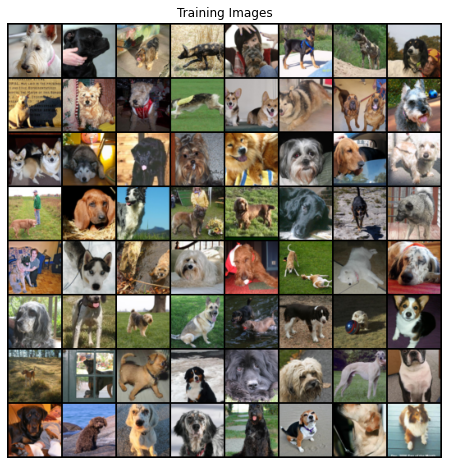

In [113]:
# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

### Models

In [114]:
class OurDCGANs(nn.Module): 
    def __init__(self, lr = 0.0002, epochs = 5, batch_size=128): #default value from original DCGAN paper
        super(DCGAN, self).__init__()
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.g = Generator()
        self.d = Discriminator()
        self.apply(weights_init)
        
    def forward(self, x):
        return self.g(x)
    

In [115]:
class Generator(nn.Module):
    def __init__(self, mapsize = 64):  #mapsize = depth = # of feature map, default =128, from paper
        super(Generator, self).__init__()
        
        #reshape uniform noise distribution Z (100)--fully connected  to 4-dimensional tensor 
        #100->1024: project + reshape
        self.conv1 = nn.ConvTranspose2d(100, mapsize*8, kernel_size=4, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(mapsize*8)
        
        #second layer: fractionaly-strided convolution 
        self.conv2 = nn.ConvTranspose2d(mapsize*8, mapsize*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mapsize*4)

        self.conv3 = nn.ConvTranspose2d(mapsize*4, mapsize*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(mapsize*2)

        self.conv4 = nn.ConvTranspose2d(mapsize*2, mapsize, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(mapsize)
        
        self.conv5 = nn.ConvTranspose2d(mapsize, 3, kernel_size=4, stride=2, padding=1, bias=False)  
        
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.tanh(self.conv5(x))
        return x

In [116]:
class Discriminator(nn.Module):
    def __init__(self, mapsize = 64): #default 128, from the paper
        super(Discriminator, self).__init__()
        
        #layer1: upsample
        self.conv1 = nn.Conv2d(3, mapsize, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(mapsize)

        #layer2: upsample
        self.conv2 = nn.Conv2d(mapsize, mapsize*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(mapsize*2)

        #layer3: upsample
        self.conv3 = nn.Conv2d(mapsize*2, mapsize*4, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(mapsize*4)

        #layer4: upsample
        self.conv4 = nn.Conv2d(mapsize*4, mapsize*8, kernel_size=4, stride=2, padding=1, bias=False)
        self.bn4 = nn.BatchNorm2d(mapsize*8)
        
        #layer5: upsample
        self.conv5 = nn.Conv2d(mapsize*8, 1, kernel_size=4, stride=1, padding=0, bias=False)
        
        
        self.lrelu = nn.LeakyReLU(negative_slope = 0.15, inplace = True) #angle = 0.15 
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        self.lrelu(x)
        x = self.conv2(x)
        self.lrelu(x)
        x = self.bn2(x)
        x = self.conv3(x)
        self.lrelu(x)
        x = self.bn3(x)
        x = self.conv4(x)
        self.lrelu(x)
        x = self.bn4(x)
        x = self.conv5(x)
        x = self.sig(x)
        return x

### Weight Initialization for models

In [117]:
# will be applied to generator & discriminator
def weights_init(model):
    classname = model.__class__.__name__
    
    if classname.find('Conv') != -1:
        #weight initialization for conv2d layers
        nn.init.normal_(model.weight.data, 0.0, 0.02)   #if conv2d layer: normal distribution with mean 0 and standard deviation 0.02


    elif classname.find('BatchNorm') != -1:
        #weight initialization for BN layers
        nn.init.normal_(model.weight.data, 1.0, 0.02)   #if BN layer: normal distribution with mean 1 and standard deviation 0.02

        #bias initialization for BN layers
        nn.init.constant_(model.bias.data, 0)           #fill 0 to tensor 
            

In [118]:
#instantialize model (gen & dis)
generator = Generator().to(device=device)           #mapsize = 64 

#initialize weights, bias to generator
generator.apply(weights_init)

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (relu): ReLU()
  (tanh): Tanh()
)

In [119]:
#instantialize model (gen & dis)
discriminator = Discriminator().to(device=device)   #mapsize = 64

#initialize weights, bias to discriminator
discriminator.apply(weights_init)

Discriminator(
  (conv1): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (lrelu): LeakyReLU(negative_slope=0.15, inplace=True)
  (sig): Sigmoid()
)

In [120]:
# Initialize the  Binary Cross Entropy Loss
criterion = nn.BCELoss() #BCEWithLogitsLoss()

# batch of latent vectors that will be used to visualize the progression of generator
# output tensor shape:64*100*1*1
fixed_noise = torch.randn(64, 100, 1, 1, device=device) 


# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.


# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=0.00025, betas=(0.5, 0.999)) #betas 0.5,0.999 from original paper
optimizerG = optim.Adam(generator.parameters(), lr=0.00033, betas=(0.5, 0.999))

# optimizerD = optim.SGD(netD.parameters(), lr = 0.00025)
# optimizerG = optim.SGD(netG.parameters(), lr = 0.00032)

### Training Loop

In [125]:
# Store training losses
g_losses = []
d_losses = []

# Store generated images
img_list = []


iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        
        
        
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        
        
        
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 40 == 0:  #i = len(dataloader)
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/80][0/81]	Loss_D: 0.4340	Loss_G: 3.4548	D(x): 0.8480	D(G(z)): 0.1608 / 0.0864
[0/80][40/81]	Loss_D: 1.3280	Loss_G: 6.3682	D(x): 0.8299	D(G(z)): 0.5063 / 0.0265
[0/80][80/81]	Loss_D: 0.6009	Loss_G: 3.4840	D(x): 0.8848	D(G(z)): 0.2930 / 0.0715
[1/80][0/81]	Loss_D: 0.5255	Loss_G: 3.8241	D(x): 0.8512	D(G(z)): 0.2229 / 0.0451
[1/80][40/81]	Loss_D: 0.9896	Loss_G: 3.9471	D(x): 0.8680	D(G(z)): 0.4542 / 0.0397
[1/80][80/81]	Loss_D: 1.2903	Loss_G: 1.5632	D(x): 0.4382	D(G(z)): 0.0588 / 0.3256
[2/80][0/81]	Loss_D: 1.1726	Loss_G: 3.9882	D(x): 0.8747	D(G(z)): 0.5286 / 0.0417
[2/80][40/81]	Loss_D: 3.0059	Loss_G: 2.7202	D(x): 0.9449	D(G(z)): 0.8555 / 0.1875
[2/80][80/81]	Loss_D: 0.6681	Loss_G: 3.0336	D(x): 0.7601	D(G(z)): 0.2433 / 0.1028
[3/80][0/81]	Loss_D: 0.7771	Loss_G: 3.3800	D(x): 0.7673	D(G(z)): 0.2987 / 0.0668
[3/80][40/81]	Loss_D: 1.3263	Loss_G: 1.0829	D(x): 0.3871	D(G(z)): 0.0737 / 0.4370
[3/80][80/81]	Loss_D: 0.8241	Loss_G: 2.6135	D(x): 0.6968	D(G(z)): 0.2921 / 0

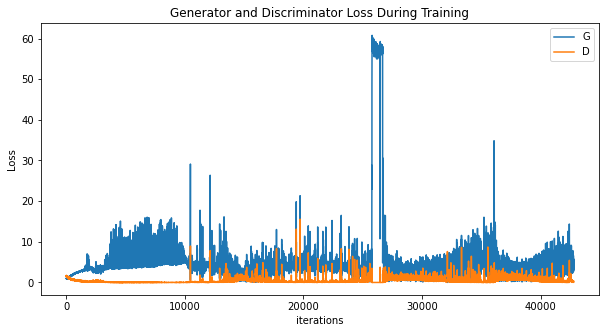

In [130]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

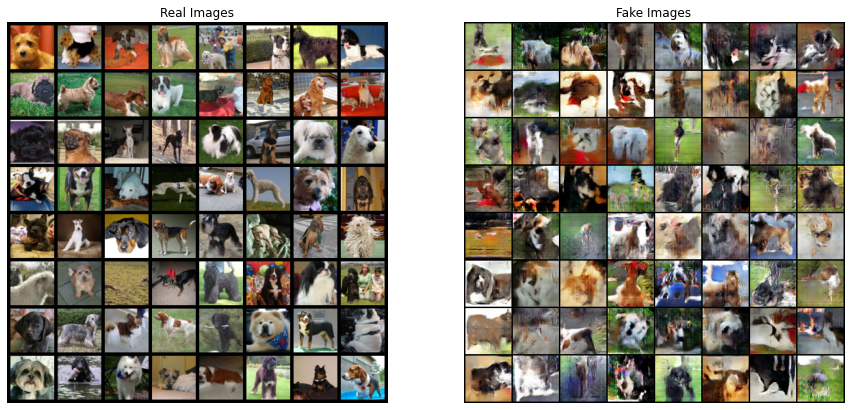

In [128]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()